#### Project Title: Multi-Task Gaussian Process Modeling for Air Quality Prediction

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import inv as inv
from scipy.linalg import cholesky as ch1
from numpy.linalg import cholesky as ch2
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

### 1. Loading and Cleaning the Data 

#### 1.1 Load Dataset
The dataset contains a few paragrpahs of explanation regarding the provided dataset. These rows will need to be omitted from the data to be loaded so that only the table of data is read. We will proceed to assign them arbitrary header names, except for the columns we are interested in, which are columns indexed 3 and 4 of the dataframe. These will be labelled 'Date' and 'CO2'/'N2O'/'SF6' respectively depending on the dataset imported.

In [2]:
df1 = pd.read_csv('co2_mm_gl.csv',skiprows = 39, header=None)
df1.columns = ['.','.','Date','CO2','.','.','.']
df1 = df1[:-1]
df1.describe()

,.,.,Date,CO2,.,.,.
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,2001.000000,6.500000,2001.500000,373.789278,0.099074,373.789426,0.060963
std,12.999215,3.455253,13.002402,24.253530,0.029846,24.225785,0.016076
min,1979.000000,1.000000,1979.042000,334.360000,0.030000,335.920000,0.030000
25%,1990.000000,3.750000,1990.271000,353.655000,0.080000,353.737500,0.050000
50%,2001.000000,6.500000,2001.500000,370.685000,0.095000,370.445000,0.060000
75%,2012.000000,9.250000,2012.729000,393.320000,0.110000,393.350000,0.070000
max,2023.000000,12.000000,2023.958000,421.570000,0.290000,420.910000,0.110000


In [3]:
# df2 = pd.read_csv('ch4_mm_gl.csv',skiprows = 47, header=None)
# df2.columns = ['.','.','Date','CH4','.','.','.']
# df2.describe()

In [4]:
df2 = pd.read_csv('n2o_mm_gl.csv',skiprows = 47, header=None)
df2.columns = ['.','.','Date','N2O','.','.','.']
df2.describe()

,.,.,Date,N2O,.,.,.
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,2012.000000,6.500000,2012.500000,325.527572,-0.264203,325.527609,-0.274783
std,6.645299,3.458323,6.651543,6.199969,1.985144,6.200651,1.982986
min,2001.000000,1.000000,2001.042000,316.110000,-9.990000,316.030000,-9.990000
25%,2006.000000,3.750000,2006.771000,319.955000,0.130000,319.970000,0.120000
50%,2012.000000,6.500000,2012.500000,324.965000,0.140000,325.045000,0.130000
75%,2018.000000,9.250000,2018.229000,330.692500,0.140000,330.587500,0.132500
max,2023.000000,12.000000,2023.958000,337.310000,0.170000,337.200000,0.150000


In [5]:
df3 = pd.read_csv('sf6_mm_gl.csv',skiprows = 47, header=None)
df3.columns = ['.','.','Date','SF6','.','.','.']
df3.describe()

,.,.,Date,SF6,.,.,.
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,2010.245283,6.556604,2010.750000,7.334057,-0.337673,7.334403,-0.344434
std,7.664673,3.457028,7.661907,2.214473,1.829970,2.214287,1.828687
min,1997.000000,1.000000,1997.542000,4.000000,-9.990000,4.010000,-9.990000
25%,2004.000000,4.000000,2004.145750,5.385000,0.010000,5.385000,0.000000
50%,2010.000000,7.000000,2010.750000,7.095000,0.010000,7.105000,0.000000
75%,2017.000000,10.000000,2017.354250,9.222500,0.010000,9.202500,0.000000
max,2023.000000,12.000000,2023.958000,11.600000,0.010000,11.590000,0.010000


#### 1.2 Data Cleaning
We will now extract the two columns of interest into a new dataset.

In [6]:
data1 = df1[['Date','CO2']]
data2 = df2[['Date','N2O']]
data3 = df3[['Date','SF6']]

#### 1.3 Split the Data into Train and Test Data

$CO_{2}$ dataset has plenty of data but the $N_{2}O$ and $SF_{6}$  datasets are more recent. So, to ensure the comparison over the same time period, we are only going to run the test data from 2002 to 2022. The remaining data from 2022 to 2023 will be used as training data.

In [7]:
start_year = 2002
test_year = 2022

df1_test = data1[data1['Date']<test_year]
df1_test = df1_test[df1_test['Date']>= start_year]
df1_train = data1[data1['Date']>= test_year]


X1_Train, Y1_Train = df1_test.iloc[:, 0].values.reshape(-1, 1), df1_test.iloc[:, 1].values
X1_Test, Y1_Test = df1_train.iloc[:, 0].values.reshape(-1, 1), df1_train.iloc[:, 1].values

print(Y1_Test.shape)

df2_test = data2[data2['Date']< test_year]
df2_test = df2_test[df2_test['Date']>= start_year]
df2_train = data2[data2['Date']>= test_year]


X2_Train, Y2_Train = df2_test.iloc[:, 0].values.reshape(-1, 1), df2_test.iloc[:, 1].values
X2_Test, Y2_Test = df2_train.iloc[:, 0].values.reshape(-1, 1), df2_train.iloc[:, 1].values

print(Y2_Test.shape)

df3_test = data3[data3['Date']< test_year]
df3_test = df3_test[df3_test['Date']>= start_year]
df3_train = data3[data3['Date']>= test_year]

X3_Train, Y3_Train = df3_test.iloc[:, 0].values.reshape(-1, 1), df3_test.iloc[:, 1].values
X3_Test, Y3_Test = df3_train.iloc[:, 0].values.reshape(-1, 1), df3_train.iloc[:, 1].values

print(Y3_Test.shape)

(24,)
(24,)
(24,)


#### 1.4 Visualise the Dataset

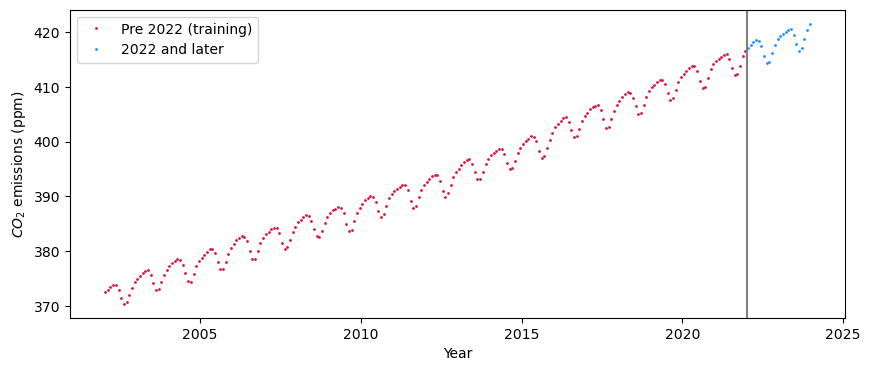

In [8]:
fig1 = plt.figure(figsize=(10,4))
plt.plot(df1_test['Date'].values, df1_test['CO2'].values, 'o', ms=1, color='crimson', label='Pre {} (training)'.format(test_year))
plt.plot(df1_train['Date'].values, df1_train['CO2'].values, 'o', ms=1, color='dodgerblue', label='{} and later'.format(test_year))
plt.legend()
plt.axvline(x=test_year, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$CO_2$ emissions (ppm)')
plt.show()

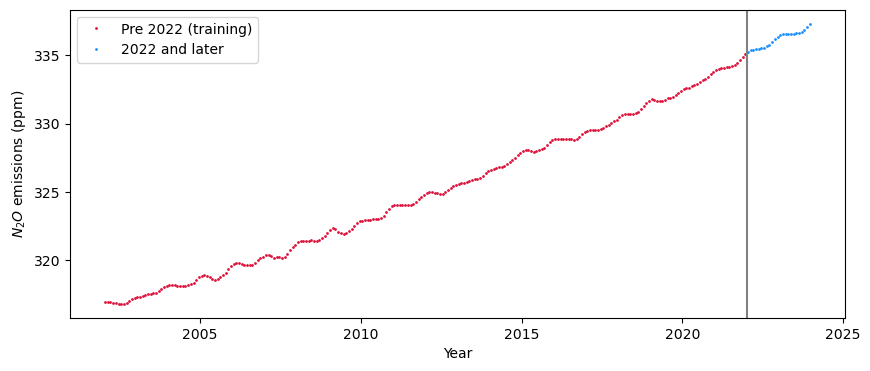

In [9]:
fig2 = plt.figure(figsize=(10,4))
plt.plot(df2_test['Date'].values, df2_test['N2O'].values, 'o', ms=1, color='crimson', label='Pre {} (training)'.format(test_year))
plt.plot(df2_train['Date'].values, df2_train['N2O'].values, 'o', ms=1, color='dodgerblue', label='{} and later'.format(test_year))
plt.legend()
plt.axvline(x=test_year, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$N_{2}O$ emissions (ppb)')
plt.show()

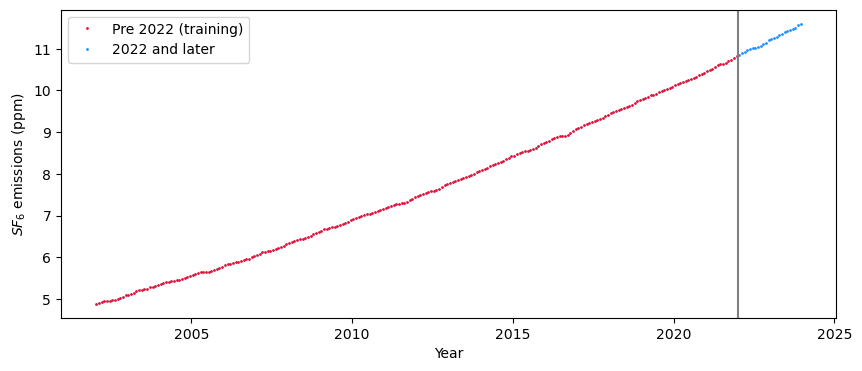

In [10]:
fig3 = plt.figure(figsize=(10,4))
plt.plot(df3_test['Date'].values, df3_test['SF6'].values, 'o', ms=1, color='crimson', label='Pre {} (training)'.format(test_year))
plt.plot(df3_train['Date'].values, df3_train['SF6'].values, 'o', ms=1, color='dodgerblue', label='{} and later'.format(test_year))
plt.legend()
plt.axvline(x=test_year, color="grey")
plt.xlabel('Year')
plt.ylabel(r'$SF_6$ emissions (ppt)')
plt.show()

### 2. Building the GP Model

#### 2.1 Defining the Kernel Function
From the data trend above, we observe that there is a gentle increasing trend in the data points. But there is also a local periodic fluctuation throughout the dataset. The period of the fluctuation is one year. Hence, we would need kernels to account for both the increasing and the periodic trends.

With reference from the Rasmussen, we will first use the squared exponential (SE) covariance kernel from equation (5.15) as shown here:
$$
k_1(x, x') = {\theta_1}^2\exp\left(- \frac{{(x - x')^2}}{{2{\theta_2}^2}}\right) \tag{5.15}
$$
This term will account for the general gradually increasing exponential trend of the dataset.

Now, for the periodic pattern, we will implement the second kernel as defined in equation (5.16) with the sinusoidal component included and a decay term. The period has been set to one year.

$$
k_2(x, x') = {\theta_3}^2\exp\left(- \frac{{(x - x')^2}}{{2{\theta_4}^2}} - \frac{2\sin^2(\pi(x - x'))} {{\theta_5}^2}\right) \tag{5.16}
$$

We will also include a third rational quadratic kernel to account for small to medium irregularities within each period using equation (5.17).

$$
k_3(x, x') = {\theta_6}^2\left(1 + \frac{(x - x')^2}{2\theta_8{\theta_7}^2}\right)^{-\theta_8} \tag{5.17}
$$

$\theta_1$, $\theta_2$, $\theta_3$, $\theta_4$, $\theta_5$, $\theta_6$, $\theta_7$, $\theta_8$ are hyperparameters to be optimized.

In [11]:
def combined_kernel(X1, X2, hyper):
    # Extract the hyperparameters from the hyper vector
    theta_1 = hyper[0]
    theta_2 = hyper[1]
    theta_3 = hyper[2]
    theta_4 = hyper[3]
    theta_5 = hyper[4]
    theta_6 = hyper[5]
    theta_7 = hyper[6]
    theta_8 = hyper[7]
    
    # Calculate the square distance term
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    
    # Define the RBF Kernel
    k1 = theta_2**2 * np.exp(-0.5 / theta_1**2 * sqdist)
    
    # Define a periodic Kernel
    k2 = theta_3**2 * np.exp((-sqdist/(2*theta_4**2)) - (2*(np.sin(np.pi*np.sqrt(sqdist)))**2)/theta_5**2)
    
    # Define a Rational Quadratic Term
    k3 = theta_6**2 * (1 + (sqdist/(2*theta_8*theta_7**2)))**(-theta_8)
    
    return k1 + k2 + k3

#### 2.2 Kronecker Product Kernel

The Kronecker product is taken to integrate the correlations between different dimensions of the data (specified by C) with the relationships captured by the combined kernel function (combined_kernel: K). This allows for a comprehensive modeling of the data structure and relationships, incorporating both the intrinsic data relationships and any specified correlations between dimensions.

$$
C \otimes K = 
\begin{bmatrix}
c_{11}K & c_{12}K & c_{13}K \\
c_{21}K & c_{22}K & c_{23}K \\
c_{31}K & c_{32}K & c_{33}K \\
\end{bmatrix}
$$

The covariance matrix C is a symmetric matrix where the diagonal terms are 1 but the rest of the terms represent the correlation between the 3 datasets that we are training our model on. We take the kronecker product of this C matrix with the kernel from the combined_kernel function to obtain the overall kernel. 




In [12]:
def kernel(xa, xb, hyper):
    rho_12 = 0.8 
    rho_13 = 0.3 
    rho_23 = 0.5 
    C = np.array([[1.0, rho_12, rho_13],
                  [rho_12, 1.0, rho_23],
                  [rho_13, rho_23, 1.0]])
    K = combined_kernel(xa,xb,hyper)
    return np.kron(C, K) # Kronecker product between C and K

#### 2.3 Defining Posterior
We will be building the posterior with the assumption that the training data has noise. By definition, the training and test data is again a GP which can be partitioned like defined in Lecture 10 as follows:

$$
\left[\begin{array}{c}
\mathbf{X_{train}}\\
\mathbf{X_{test}}
\end{array}\right]\sim\mathcal{N}\left( 0, \begin{bmatrix}
\mathbf{C_{y}} & \mathbf{R}\\
\mathbf{R}^{T} & \mathbf{C^{*}}
\end{bmatrix}\right)
$$

where $C_{y} = C + {\sigma_y}^2 I_N$ is the covariance matrix on the training data, and $\sigma_y$ is the noise term associated with the training data. $R$ is the cross covariance matrx on training and test data, and $C^{*}$ is the covariance matrix on the test data. 

We will then use these matrices to calculate the mean and covariance as defined in Lecture 10 as follows:
$$
\mu_s = R^{T}{C_{y}}^{-1}t \\
cov_s = C^{*} - R^{T}C^{-1}R
$$
where $t$ is the observed training output,

In [13]:
def posterior(x, x_data, y_data, hyper, sigma_y=1e-8):
    u = y_data.shape[0]
    mu_y = np.mean(y_data)
    y = (y_data - mu_y).reshape(u,1)
    
    Sigma = np.eye(u)
    m = int(u/3)
    for i in range(m):
        Sigma[i][i] = sigma_y[0]
        Sigma[i+m][i+m]= sigma_y[1]
        Sigma[i+2*m][i+2*m] = noise[2]
    
    Kxx = kernel(x_data, x_data, hyper) + Sigma
    Kxpx = kernel(x, x_data, hyper)
    Kxpxp = kernel(x, x, hyper)
    
    # Inverse
    jitter = np.eye(u) * 1e-1
    L = ch1(Kxx + jitter)
    S1 = solve_triangular(L.T, y, lower=True)
    S2 = solve_triangular(L.T, Kxpx.T, lower=True).T
    
    mu_s = S2 @ S1  + mu_y
    cov_s = Kxpxp - S2 @ S2.T
    return mu_s, cov_s

### 3. Hyperparameter Optimization
We will be using maximum log likelihood to do the hyperparameter inference. The log likelihood is as given in equation 5.8 in the Rasmussen textbook.
$$
\log p(\mathbf{y}|\mathbf{X},\theta) = -\frac{1}{2}\mathbf{y}^TK_y^{-1}\mathbf{y} - \frac{1}{2}\log|K_y| - \frac{n}{2}\log 2\pi,
\tag{5.8}
$$
To set the hyperparameters by maximizing the marginal likelihood, we seek the partial derivatives of the marginal likelihood w.r.t. the hyperparameters. From Rasmussen textbook, chapter 5, equation 5.9:
$$
\frac{\partial}{\partial\theta_j}\log p(\mathbf{y}|\mathbf{X},\theta) = \frac{1}{2}\mathbf{y}^TK^{-1}\frac{\partial K}{\partial\theta_j}K^{-1}\mathbf{y} - \frac{1}{2}\text{tr}\left(K^{-1}\frac{\partial K}{\partial\theta_j}\right)
= \frac{1}{2}\text{tr}\left((\boldsymbol{\alpha\alpha}^T - K^{-1})\frac{\partial K}{\partial\theta_j}\right) \quad \text{where} \quad \boldsymbol{\alpha} = K^{-1}\mathbf{y}. \tag{5.9}
$$

For the purposes of this project, we will be passing the log likelihood into the scipy.optimize.minimize to run an in-built gradient optimization and return the optimized hyperparameters.

In [14]:
def nll_fn(X_train, Y_train, noise):
    def nll_stable(theta):
        u = Y_train.shape[0]
        Sigma = np.eye(u)
        m = int(u/3)
        for i in range(m):
            Sigma[i][i] = noise[0]
            Sigma[i+m][i+m]= noise[1]
            Sigma[i+2*m][i+2*m] = noise[2]
        
        K = kernel(X_train, X_train, theta) + Sigma*0.7 
        L = ch2(K)

        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)
        
        # Evaluate Log Likelihood
        Ll = np.sum(np.log(np.diagonal(L))) + 0.5 * Y_train.dot(S2) + 0.5 * len(X_train) * np.log(2*np.pi)
        
        x = X_train
        x_prime = x

        return Ll
    return nll_stable

### 4. Running for $CO_{2}$, $N_{2}O$ & $SF_{6}$ Data

The objective of this project is to be able to predict the trend of the three pollutants from a single GP model. The target is to show that these data are correlated. To achieve this objective, we will gather historical data on atmospheric concentrations of carbon dioxide ($CO_{2}$), nitrous oxide ($N_{2}O$), and sulfur hexafluoride ($SF_{6}$).  By training the GP model on the collected data, we aim to develop a predictive model capable of forecasting the trends of $CO_{2}$, $N_{2}O$, and $SF_{6}$ simultaneously. This unified approach will allow us to discern potential interdependencies and common patterns among the three pollutants, providing valuable insights into their atmospheric dynamics and facilitating more comprehensive environmental assessments.

In [15]:
# Minimize the negative log-likelihood w.r.t. all hyperparameters.
sigma_1 = 0.1
sigma_2 = 0.16
sigma_3 = 0.1
noise = np.array([sigma_1, sigma_2, sigma_3])
hyper_initial = [1, 1, 1, 1, 1, 1, 1, 1]

Y_Train_combined = np.hstack([Y1_Train, Y2_Train, Y3_Train])


res = minimize(nll_fn(X1_Train, Y_Train_combined, noise), hyper_initial, 
               bounds=((1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)),
               method='L-BFGS-B')


# Extract the optimized hyperparameter values
hyper_opt = res.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu1_s, cov1_s = posterior(X1_Test, X1_Train, Y_Train_combined, hyper_opt, sigma_y=noise)

#### 4.1 Plotting the Test Data 
We plot the predictions and the actual test data on the same plot for all three pollutants. Clearly, this is not the best representation due to the scale difference between the pollutants. As such, the pollutants are plotted on individual plots in the lines below.

Text(0, 0.5, 'Mole fraction')

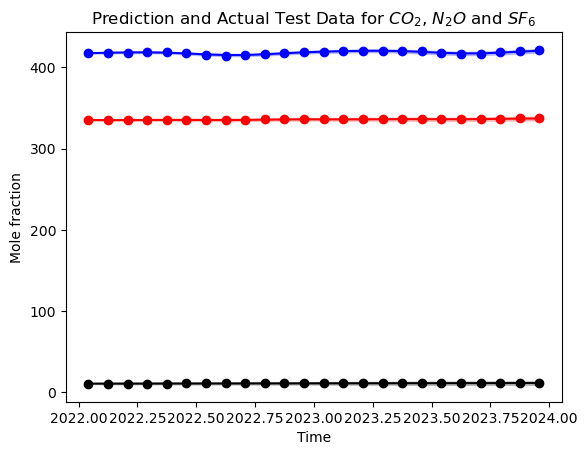

In [16]:
# Task 1
M = len(X1_Test)
mu_1 = mu1_s[0:M].ravel()
std_1 = np.sqrt(np.diag(cov1_s))[0:M].flatten()

# Task 2
mu_2 = mu1_s[M:2*M].ravel()
std_2 = np.sqrt(np.diag(cov1_s))[M:2*M].flatten()

# Task 3
mu_3 = mu1_s[2*M:].ravel()
std_3 = np.sqrt(np.diag(cov1_s))[2*M:].flatten()

X1 = X1_Test.ravel()
Y1 = Y1_Test.ravel()
Y2 = Y2_Test.ravel()
Y3 = Y3_Test.ravel()

fig4 = plt.figure()
plt.plot(X1,Y1,'bo')
plt.plot(X1,Y2,'ro')
plt.plot(X1,Y3,'ko')


# Task 1
plt.plot(X1,mu_1,'b-')
plt.fill_between(X1,mu_1 + std_1, mu_1 - std_1, color = 'blue', alpha = 0.2)

# Task 2
plt.plot(X1,mu_2,'r-')
plt.fill_between(X1,mu_2 + std_2, mu_2 - std_2, color = 'red', alpha = 0.2)

# Task 3
plt.plot(X1,mu_3,'k-')
plt.fill_between(X1,mu_3 + std_3, mu_3 - std_3, color = 'black', alpha = 0.2)

plt.title(r'Prediction and Actual Test Data for $CO_{2}$, $N_{2}O$ and $SF_{6}$')
plt.xlabel('Time')
plt.ylabel(r'Mole fraction')

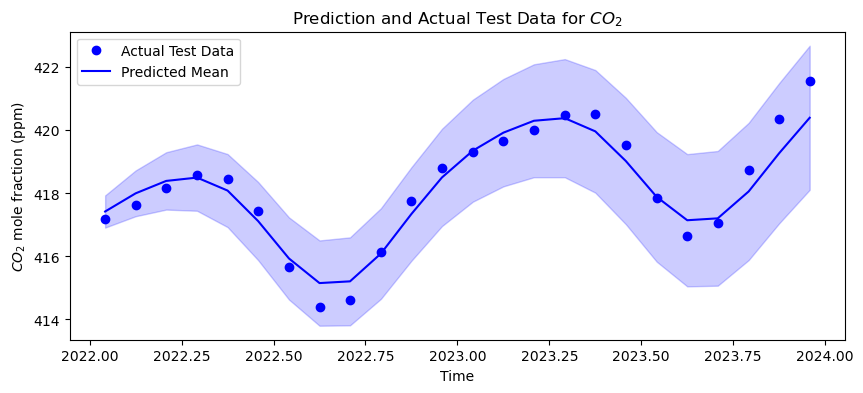

In [17]:
fig5 = plt.figure(figsize=(10,4))
plt.plot(X1,Y1,'bo',label = 'Actual Test Data')
plt.plot(X1,mu_1,'b-', label = 'Predicted Mean')
plt.fill_between(X1,mu_1 + std_1, mu_1 - std_1, color = 'blue', alpha = 0.2)
plt.title(r'Prediction and Actual Test Data for $CO_{2}$')
plt.xlabel('Time')
plt.ylabel(r'$CO_{2}$ mole fraction (ppm) ')
plt.legend()

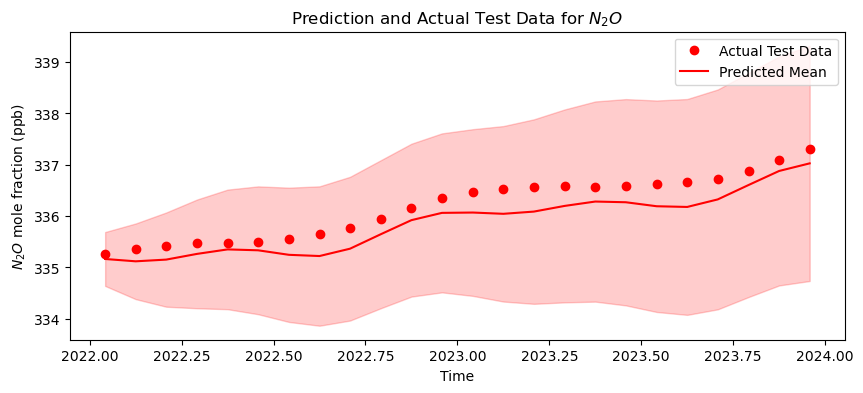

In [18]:
fig6 = plt.figure(figsize=(10,4))
plt.plot(X1,Y2,'ro',label = 'Actual Test Data')
plt.plot(X1,mu_2,'r-', label = 'Predicted Mean')
plt.fill_between(X1,mu_2 + std_2, mu_2 - std_2, color = 'red', alpha = 0.2)
plt.title(r'Prediction and Actual Test Data for $N_{2}O$')
plt.xlabel('Time')
plt.ylabel(r'$N_{2}O$ mole fraction (ppb) ')
plt.legend()

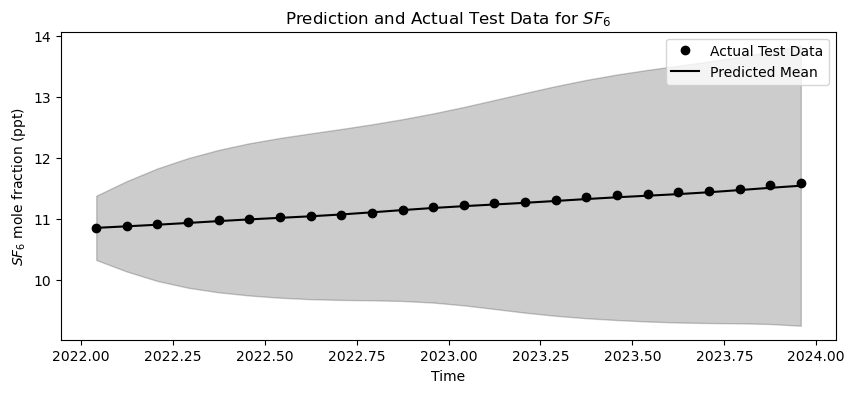

In [19]:
fig7 = plt.figure(figsize=(10,4))
plt.plot(X1,Y3,'ko',label = 'Actual Test Data')
plt.plot(X1,mu_3,'k-',label = 'Predicted Mean')
plt.fill_between(X1,mu_3 + std_3, mu_3 - std_3, color = 'black', alpha = 0.2)
plt.title(r'Prediction and Actual Test Data for $SF_{6}$')
plt.xlabel('Time')
plt.ylabel(r'$SF_{6}$ mole fraction (ppt) ')
plt.legend()